In [1]:
import pandas as pd
import matplotlib.pyplot as plt


df_stats = pd.read_csv("/home/jupyter-daniela/suyana/peru_production/outputs/calas_estadisticas.csv")

# Crear archivo de fechas por empresa similar al de temporadas
empresas_equivalentes = {
    "AUSTRAL GROUP SAA": "AUSTRAL GROUP SAA",
    "CFG-COPEINCA": "COPEINCA",
    "HAYDUK": "HAYDUK",
    "TASA": "TASA",
    "TASA ": "TASA",
    "PESQUERA CENTINELA S.A.C": "CENTINELA S.A.C",
    "CENTINELA": "CENTINELA S.A.C",
    "PESQUERA DIAMANTE S.A.": "DIAMANTE S.A.",
    "DIAMANTE": "DIAMANTE S.A.",
    "Pesquera Diamante S.A.": "DIAMANTE S.A.",
    "PESQUERA EXALMAR S.A.A.": "EXALMAR S.A.A.",
    "CAPRICORNIO": "CAPRICORNIO",
    "INVERSIONES QUIAZA SAC": "INVERSIONES QUIAZA SAC",
    "QUIAZA": "INVERSIONES QUIAZA SAC",
    "PESQ. ISA": "ISA",
    "LOS HALCONES SA": "LOS HALCONES SA",
    "LOS HALCONES": "LOS HALCONES SA",
    "Inversiones Eccola": "INVERSIONES ECCOLA",
    "INVERSIONES ECCOLA": "INVERSIONES ECCOLA",
    "PESQ. NINFAS DEL MAR": " NINFAS DEL MAR",
    "PESQ. MAJAT": "MAJAT",
    "PESQUERA LUCIANA SAC": "LUCIANA SAC",
    "PESQUERA SKAVOS S.A.C.": "SKAVOS S.A.C."
}

df_stats["empresa_normalizada"] = df_stats["empresa"].replace(empresas_equivalentes)
df_empresas_fechas = df_stats.groupby(["empresa_normalizada", "temporada"]).agg({
    'fecha_inicio': 'min',
    'fecha_fin': 'max'
}).reset_index()

In [2]:
df_empresas_fechas.columns = ['empresa', 'temporada', 'fecha_inicio', 'fecha_fin']

In [3]:
print("Ejemplo de fechas por empresa para 1ra 2020:")
sample = df_empresas_fechas[df_empresas_fechas['temporada'] == '1ra 2020']
print(sample[['empresa', 'fecha_inicio', 'fecha_fin']])

print("\n¿Son todas las fechas de inicio iguales en 1ra 2020?")
print(sample['fecha_inicio'].nunique() == 1)

print("\n¿Son todas las fechas de fin iguales en 1ra 2020?")
print(sample['fecha_fin'].nunique() == 1)

print("\nRango de fechas por temporada:")
for temp in df_empresas_fechas['temporada'].unique()[:5]:
    temp_data = df_empresas_fechas[df_empresas_fechas['temporada'] == temp]
    print(f"{temp}: {temp_data['fecha_inicio'].nunique()} fechas inicio diferentes, {temp_data['fecha_fin'].nunique()} fechas fin diferentes")

Ejemplo de fechas por empresa para 1ra 2020:
               empresa fecha_inicio   fecha_fin
6    AUSTRAL GROUP SAA   2020-05-16  2020-07-20
30     CENTINELA S.A.C   2020-05-13  2020-07-05
46            COPEINCA   2020-05-13  2020-07-19
64       DIAMANTE S.A.   2020-05-14  2020-07-05
80      EXALMAR S.A.A.   2020-05-15  2020-07-24
96              HAYDUK   2020-05-13  2020-07-24
133               TASA   2020-05-13  2020-07-18

¿Son todas las fechas de inicio iguales en 1ra 2020?
False

¿Son todas las fechas de fin iguales en 1ra 2020?
False

Rango de fechas por temporada:
1ra 2023: 1 fechas inicio diferentes, 7 fechas fin diferentes
2da 2022: 3 fechas inicio diferentes, 3 fechas fin diferentes
1ra 2016: 2 fechas inicio diferentes, 3 fechas fin diferentes
1ra 2017: 2 fechas inicio diferentes, 4 fechas fin diferentes
1ra 2018: 2 fechas inicio diferentes, 6 fechas fin diferentes


In [4]:

top_empresas = df_stats.groupby("empresa_normalizada")["volumen_empresa_tm"].sum().nlargest(10).index
df_empresas_top = df_empresas_fechas[df_empresas_fechas['empresa'].isin(top_empresas)].copy()

df_empresas_top['fecha_inicio'] = pd.to_datetime(df_empresas_top['fecha_inicio'])
df_empresas_top['fecha_fin'] = pd.to_datetime(df_empresas_top['fecha_fin'])
df_empresas_top['anio'] = df_empresas_top['temporada'].str.extract(r'(\d{4})').astype(int)
df_empresas_top['tipo'] = df_empresas_top['temporada'].str.extract(r'(1ra|2da)')

def dia_pesquero(fecha):
    ref = pd.Timestamp(year=fecha.year, month=3, day=1)
    if fecha >= ref:
        return (fecha - ref).days
    else:
        ref_prev = pd.Timestamp(year=fecha.year - 1, month=3, day=1)
        return (fecha - ref_prev).days

df_empresas_top['inicio_dia'] = df_empresas_top['fecha_inicio'].apply(dia_pesquero)
df_empresas_top['fin_dia'] = df_empresas_top['fecha_fin'].apply(dia_pesquero)

mask = df_empresas_top['fin_dia'] < df_empresas_top['inicio_dia']
df_empresas_top.loc[mask, 'fin_dia'] += 365

empresas_ordenadas = list(top_empresas)
n_empresas = len(empresas_ordenadas)


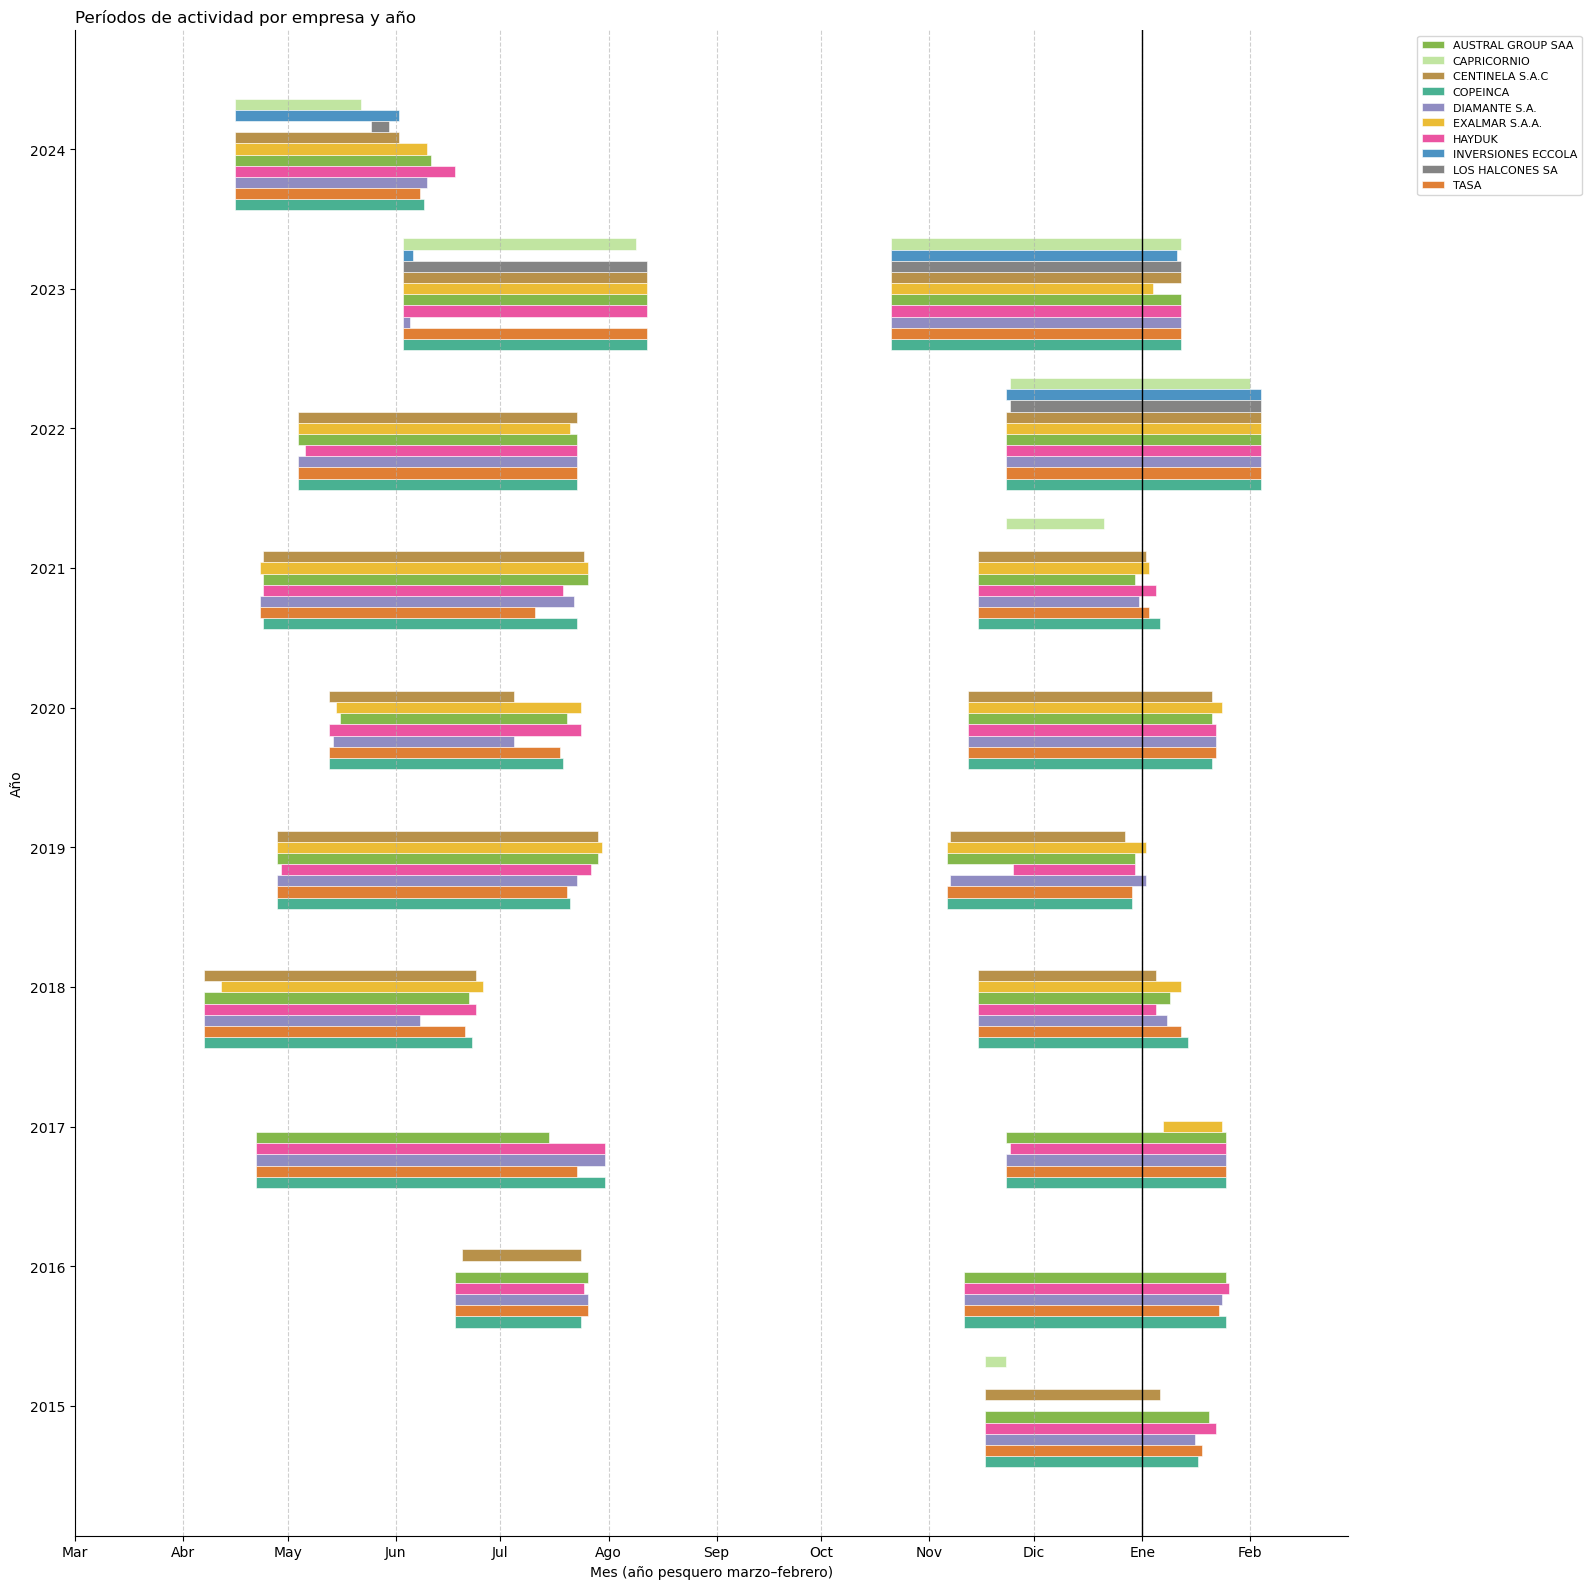

In [17]:
fig, ax = plt.subplots(figsize=(16, 16))

import numpy as np
colores_distintivos = [
    "#1B9E77",
    "#D95F02",
    "#7570B3",
    "#E7298A",
    "#66A61E",
    "#E6AB02",
    "#A6761D",
    "#666666",
    "#1F78B4",
    "#B2DF8A"
]
colores_empresas = {empresa: colores_distintivos[i] for i, empresa in enumerate(empresas_ordenadas)}

anios_unicos = sorted(df_empresas_top['anio'].unique())
altura_empresa = 0.08  # Barras más delgadas para dejar más espacio
empresas_etiquetadas = set()

for _, row in df_empresas_top.iterrows():
    anio = row['anio']
    empresa = row['empresa']
    
    y_base = anio
    empresa_idx = empresas_ordenadas.index(empresa)
    y_offset = (empresa_idx - len(empresas_ordenadas)/2) * altura_empresa
    y_pos = y_base + y_offset
    
    label = empresa if empresa not in empresas_etiquetadas else ""
    if empresa not in empresas_etiquetadas:
        empresas_etiquetadas.add(empresa)
    
    ax.barh(
        y=y_pos,
        width=row['fin_dia'] - row['inicio_dia'],
        left=row['inicio_dia'],
        color=colores_empresas[empresa],
        height=altura_empresa,
        alpha=0.8,
        edgecolor='white',  # Borde blanco
        linewidth=0.5,      # Grosor del borde
        label=label
    )

meses = ['Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic', 'Ene', 'Feb']
dias_mes = [0, 31, 61, 92, 122, 153, 184, 214, 245, 275, 306, 337]
ax.set_xticks(dias_mes)
ax.set_xticklabels(meses)

ax.set_xlim(0, 365)
ax.set_yticks(anios_unicos)
ax.set_yticklabels(anios_unicos)
ax.set_xlabel('Mes (año pesquero marzo–febrero)')
ax.set_ylabel('Año')
ax.set_title('Períodos de actividad por empresa y año', loc='left', fontsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.6)
ax.axvline(x=306, color='black', linewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()